# Conditional Probability (Discrete)

**Context:** You've already spent some time conducting a preliminary exploratory data analysis (EDA) of IHH's ER data. You noticed that considering variables separately can result in misleading information. As such, today you will continue your EDA, this time also considering the *relationship between variables*. For example, you may want to know:

* Are there certain conditions that are more likely to occur on certain days?
* What makes a patient likely to need hospitalization?

**Challenge:** So far, however, we've only seen ways of characterizing the variability/stochasticity of a univariate random phenomenon independently of other variables. So how can we consider the relationship between variables? Answer: conditional probability. 

**Outline:** 
1. Introduce and practice the concepts, terminology, and notation behind discrete conditional probability distributions (leaving continuous distributions to a later time).
2. Answer the above questions using this new toolset.

Before getting started, let's load in our IHH ER data:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load in the data into a pandas dataframe
csv_fname = 'IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of 5 patients, just to see what's in the data
data.sample(15, random_state=0)

,Day-of-Week,Condition,Hospitalized,Antibiotics,Attempts-to-Disentangle
Patient ID,,,,,
9394,Friday,Allergic Reaction,No,No,NaN
898,Sunday,Allergic Reaction,Yes,Yes,NaN
2398,Saturday,Entangled Antennas,No,No,4.0
5906,Saturday,Allergic Reaction,No,No,NaN
2343,Monday,High Fever,Yes,No,NaN
8225,Thursday,High Fever,Yes,No,NaN
5506,Tuesday,High Fever,No,No,NaN
6451,Thursday,Allergic Reaction,No,No,NaN
2670,Sunday,Intoxication,No,No,NaN


## Terminology and Notation

As with (non-conditional) discrete probability, the statistical language---terminology and notation---we introduce here will allow us to precisely specify to a computer how to model our data. In the future, we will translate statements in this language directly into code that a computer can run.

**Concept:** Conditional probabilities allow us to ask questions of the form, "given that $A$ is true, what's the probability of $B$?". Although simple, this idea is actually quite powerful; all *predictive models* you may have heard of (e.g. regression, classification, etc.) are formulated using *conditional distributions*. To see what we mean, let's start with an example.

**Example:** Suppose you're working at the IHH ER, and you want to *predict* what is the probability that the next patient comes in with `Condition == "Intoxication"`. Given previously collected data, you can estimate this probability by counting the number of patients for which `Condition == "Intoxication"` and dividing by the total number of patients:
\begin{align*}
\text{Naive Predictor} = \frac{\text{Number of patients with intoxication}}{\text{Total number of patients}}
\end{align*}

Let's compute this naive predictor on our IHH ER data:

In [3]:
num_intoxicated = len(data[data['Condition'] == 'Intoxication'])
num_total = len(data)
naive_probability_of_intoxication = num_intoxicated / float(num_total)

print('Portion with Intoxication (Naive Predictor) =', round(naive_probability_of_intoxication, 3))

Portion with Intoxication (Naive Predictor) = 0.171


However, you also know that even in far reaches of the outer universe, beings work Mondays through Fridays, taking Saturdays and Sundays off. Therefore, you suspect intoxication may be more likely to occur on weekends. You decide to check whether your intuition is true here. If it is true, will you improve your ability to predict how likely the next patient is to come with intoxication?

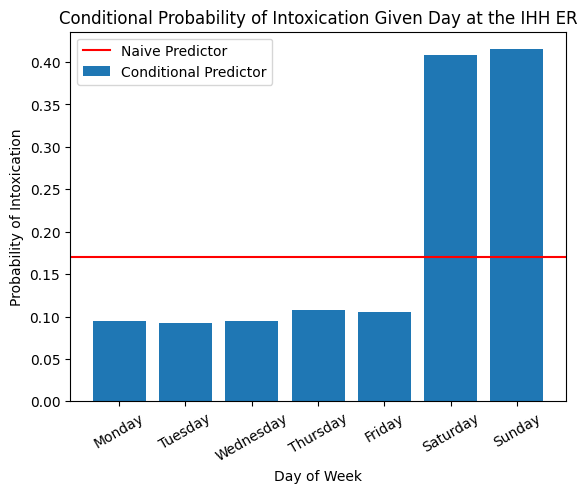

In [4]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

probabilities = []

# Iterate over the days of the week
for day in days_of_week:
    # Select all patients that came in on the specific day of the week
    patients_on_day = data[(data['Day-of-Week'] == day)]

    # Of the selected patients, further select patients with intoxication
    patient_intoxicated_on_day = patients_on_day[patients_on_day['Condition'] == 'Intoxication']

    # Compute the portion of patients with intoxication on this day
    portion_intoxicated_on_day = float(len(patient_intoxicated_on_day)) / float(len(patients_on_day))

    # Print the day and the percentage
    probabilities.append(portion_intoxicated_on_day)

# Plot!
plt.bar(days_of_week, probabilities, label='Conditional Predictor')
plt.axhline(naive_probability_of_intoxication, color='red', label='Naive Predictor')

# Add axis labels and titles
plt.xticks(rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Intoxication')
plt.title('Conditional Probability of Intoxication Given Day at the IHH ER')
plt.legend()
plt.show()

As you can see, the probability of a patient arriving with intoxication changes *significantly* from the naive predictor (above) if we consider the day of the week. Specifically, the above plot shows us that our naive predictor
1. significantly *over-estimates* the probability of intoxication on weekdays, and
2. significantly *under-estimates* the probability of intoxication on weekends.

Using a conditional distribution, we can leverage additional information (day of the week) to significantly improve our prediction!

**Definition and Notation:** A conditional probability is a probability distribution that changes as a function of another random variable. 

> Continuing with the above example, 
> * Let $D$ denote the day of the week.
> * Let $I$ denote whether the patient arrives with intoxication.
> 
> Here, $p_I(\cdot)$ describes the (non-conditional) probability that a patient arrives with intoxication. It represents our *naive*, inaccurate prediction. In contrast, $p_{I | D}(\cdot | d)$ describes the *conditional* probability of "intoxication given the day"---the probability of intoxication changes from weekdays to weekends. In this notation, what comes on the right side of the vertical line is the "condition" (here, $D = d$).

**Sample Space or Support:** Since a discrete conditional distribution is still a discrete distribution, all notation/terminology from discrete probability still holds. 

> For our running example, the sample space is that of variable to the left of the line, $I$. That is, the sample space of $p_{I | D}(\cdot | d)$ is $I \in \{ 0, 1 \}$ (with 1 means intoxicated and 0 means not intoxicated). 

**Probability Mass Function (PMF):** The PMF is, again, that of the variable to the left of the vertical line. What makes a conditional probability different from a non-conditional distribution, however, is that the parameter of the distribution is now a *function of the condition*.
> In our example, the PMF is that of a Bernoulli random variable (since $I$ can only take on two values). Since it's a *conditional* distribution, it's parameter depends on the condition (the day $D = d$). We can write this as follows:
> \begin{align*}
p_{I | D}(i | d) = \underbrace{\rho(d)^{i} \cdot \left(1 - \rho(d) \right)^{1 - i}}_{\text{Bernoulli PMF (see Wikipedia)}},
\end{align*}
> where
> \begin{align*} \rho(d) &= \begin{cases}
0.1 & \text{if $d$ is weekday} \\
0.4 & \text{if $d$ is weekend} 
\end{cases} 
\end{align*}
> In a sense, a conditional probability is the "if/else-expression of probability."

**Independent, Identically Distributed (i.i.d):** Just as before, a variable can be sampled i.i.d from a distribution.

> Given $D = d$, we write that $I$ is sampled i.i.d from the conditional as follows: $I | d \sim p_{I | D}(\cdot | d)$. This means that, given the day (e.g. $d = \mathrm{Monday}$), observing one patient with intoxication tells us nothing about the probability of observing another patient with intoxication. Note that without conditioning on the day, this is not true: observing many patients with intoxication could tell us that the current day is on a weekend, which means the probability of intoxication is higher overall.

**Summary of Notation:**
* Let $R$ and $C$ denote two RVs. 
* $R | c$ is then an RV describing "$R$ given $C = c$".
* $p_{R | C}(\cdot | c)$ is the conditional PMF of $R | c$. 
* $p_{R | C}(r | c)$ is the evaluation of the conditional PMF at $r$: i.e. given that $C = c$, what's the probability that $R = r$?
* $R | c \sim p_{R | C}(\cdot | c)$ denotes that $R | c$ is sampled i.i.d. from $p_{R | C}(\cdot | c)$

## Learning the Conditional Distributions by Hand

```{admonition} Exercise
Let us define the following RVs:
* $D$: Day-of-Week	
* $C$: Condition	
* $H$: Hospitalized	
* $A$: Antibiotics
* $M$: Attempts-to-Disentangle

Our goal is to learn the distributions of the following conditional RVs:
1. $C | d$
2. $H | c$
3. $M | c$
4. $A | c, h$ (here, we condition on *two* RVs)

**Part 1:** By exploring the data (as we did in the above example for "intoxication given day"), empirically estimate each conditional distribution above. Use the notation we introduced to write your answer. Don't forget to show your work with all the plots you generate!

**Part 2:** Compare each conditional distribution with its corresponding non-conditional version (these are called *marginals*) from before. What differences do you notice? How can the differences mislead the IHH ER?
```

TODO write your answer here.